# Cliff Walking Problem solved with TD(n) Algorithms: Implementation & Comparisons

## 1. Load Libraries & Define Environment

In [1]:
import gym
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import OrderedDict

The **OpenAI Gym toolkit** includes the below environment for the **"Cliff-Walking"** problem:

In [2]:
print('OpenAI Gym environments for Cliff Walking Problem:')
[k for k in gym.envs.registry.env_specs.keys() if k.find('Cliff' , 0) >=0]

OpenAI Gym environments for Cliff Walking Problem:


['CliffWalking-v0']

Load the **Cliff-Walking** environment:

In [3]:
env = gym.make('CliffWalking-v0')

This environment has to do about gridworld shown below, where the traveller initial position (**`x`**) and the target to achieve (reach **`T`**) has been flagged appropriately. In addition in a one of the edge of this gridwordld example there is a "Cliff" denoted with **`C`**. Reward is $-1$ on all transitions except those into the cliff region. Steppping into this region incurs a reward of $-100$ and sends the agent instantly back to the start. 

Once the environment is initialized you get the situation below. This is an episodic (undiscounted) task with start at traveller's starting point, and it is completed either when the goal is achieved, that is the traveller manage to reach the target location, **`T`**, or she may happen to step into the cliff. In this case the environment is reseted in each initial state.

In [4]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



Possible *traveller's actions* are of course her movements in this grid:
- **"UP"**:  denoted by 0
- **"RIGHT"**: denoted by 1
- **"DOWN"**: denoted by 2
- **"LEFT"**: denoted by 3

To get the *new state* at *every next step of an episode*, you may pass the current action into the `.step()` method of the environment. The environment then will return a tuple **(observation, reward, done, info)** each of which are explained as below:
- **observation (object):** agent's observation of the current environment
- **reward (float):** amount of reward returned after previous action
- **done (bool):** whether the episode has ended, in which case further step() calls will return undefined results
- **info (dict):** contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)

***Note:*** *At termination of each episode, the programmer is responsible to reset the environment.*

For further details concerning the `CliffWalking-v0` environment of **OpenAI Gym toolkit** consult the docstring below.

In [23]:
help(env)

Help on CliffWalkingEnv in module gym.envs.toy_text.cliffwalking object:

class CliffWalkingEnv(gym.envs.toy_text.discrete.DiscreteEnv)
 |  This is a simple implementation of the Gridworld Cliff
 |  reinforcement learning task.
 |  
 |  Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
 |  by Sutton and Barto:
 |  http://incompleteideas.net/book/bookdraft2018jan1.pdf
 |  
 |  With inspiration from:
 |  https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py
 |  
 |  The board is a 4x12 matrix, with (using NumPy matrix indexing):
 |      [3, 0] as the start at bottom-left
 |      [3, 11] as the goal at bottom-right
 |      [3, 1..10] as the cliff at bottom-center
 |  
 |  Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
 |  and a reset to the start. An episode terminates when the agent reaches the goal.
 |  
 |  Method resolution order:
 |      CliffWalkingEnv
 |      gym.envs.toy_text.discr

## 2. RL-Algorithms based on Temporal Difference TD(n): Prediction Problem

### 2a. Load the "Temporal Difference" Python class

Load the Python class `PlotUtils()` which provides various plotting utilities and start a new instance.

In [5]:
%run ../PlotUtils.py

In [6]:
plotutls = PlotUtils()

Load the **Temporal Difference Python class**, `TemporalDifferenceUtils()`:

In [7]:
%run ../TDn_Utils.py

Instantiate the class for the environment of interest:

In [8]:
TD = TemporalDifferenceUtils(env)

### 2b. n-step TD Prediction (estimating $V \approx v_{\pi}$)

We define the functions below to help:
1. *compute* the **optimal state-action values** of this problem, 
2. *provide* the **optimal policy** which is expected to be learned by the agent, and
3. *visualize* the **result** to *verify* that everything have been configured correctly.

In [12]:
def cliff_walking_optimal_q_values(grid_height=4, grid_width=12, cliff_index = np.s_[:,:,:]):
    
    # Define the start position
    start = [grid_height - 1, 0] 

    # Define the position of target dstination
    goal = [grid_height - 1, grid_width - 1]

    # Define a dictionary of possible actions
    actions_dict = {}
    actions = ['UP', 'RIGHT', 'DOWN', 'LEFT']
    for k, v in zip(actions, range(0, len(actions))):
        actions_dict[k] = v

    # Define a "q_values" array for grid-world of interest
    n_states = grid_height * grid_width
    n_actions = len(actions_dict)
    q_values =  np.full((grid_height, grid_width, n_actions), fill_value=-100.)

    # Determine "q_values" of optimal policy
    n_steps = grid_width
    q_values[:cliff_index[0],:,actions_dict['RIGHT']] = np.arange(0, n_steps, 1)
    q_values[start[0], start[1], actions_dict['UP']] = 0.5
    q_values[:goal[0],goal[1],actions_dict['DOWN']] = n_steps
    
    return q_values


def cliff_walking_optimal_policy(env, state):
    active_q = cliff_walking_optimal_q_values(grid_height=4, grid_width=12, cliff_index = np.s_[3,1:12,:])
    active_q = active_q.reshape((env.observation_space.n, env.action_space.n))
    return TD.epsilon_greedy_policy(env, active_q, state, epsilon=0.)


# print optimal policy
def print_optimal_policy(q_values, grid_height=4, grid_width=12):
    # Define a helper dictionary of actions
    actions_dict = {}
    actions = ['UP', 'RIGHT', 'DOWN', 'LEFT']
    for k, v in zip(actions, range(0, len(actions))):
        actions_dict[k] = v
        
    # Define the position of target dstination
    GOAL = [3, 11]
        
    # Reshape the "q_values" table to follow grid-world dimensionality
    q_values = q_values.reshape((grid_height, grid_width, len(actions)))
        
    optimal_policy = []
    for i in range(0, grid_height):
        optimal_policy.append([])
        for j in range(0, grid_width):
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_values[i, j, :])
            if bestAction == actions_dict['UP']:
                optimal_policy[-1].append('\U00002191')
            elif bestAction == actions_dict['RIGHT']:
                optimal_policy[-1].append('\U00002192')
            elif bestAction == actions_dict['DOWN']:
                optimal_policy[-1].append('\U00002193')
            elif bestAction == actions_dict['LEFT']:
                optimal_policy[-1].append('\U00002190')
    for row in optimal_policy:
        print(*row)

Verify that the optimal policy has been configured correctly.

In [10]:
active_q = cliff_walking_optimal_q_values(grid_height=4, grid_width=12, cliff_index = np.s_[3,1:12,:])
print_optimal_policy(active_q, grid_height=4, grid_width=12)

→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G


Use the `temporal_difference_prediction()` method to predict the **state values** if the agent let to follow a **5-step TD** learning path.

In [11]:
runs=10; n_episodes = 100
s_values = TD.temporal_difference_prediction(env, cliff_walking_optimal_policy,
                                             runs=runs, n_episodes=n_episodes, decimals=2,
                                             n_step=6, step_size=0.3, discount=1., epsilon=0.1)

Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Estimating state values for TD(5)...


Independent Runs: 100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


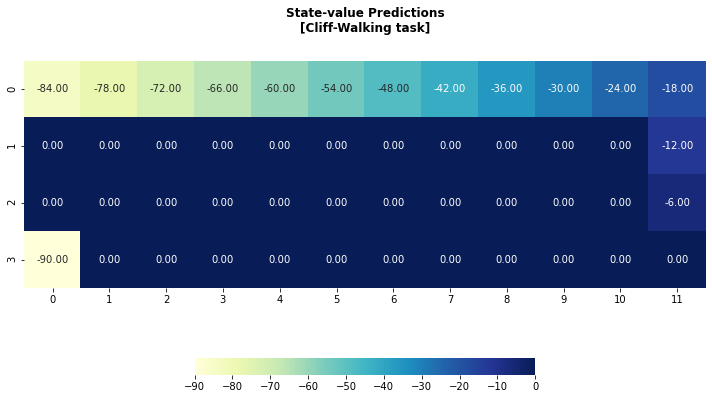

In [12]:
title = 'State-value Predictions\n[Cliff-Walking task]'
plotutls.plot_state_values(s_values, grid_height=4, grid_width=12, title=title)

## 3. RL-Algorithms based on Temporal Difference TD(n): Control Problem

### 3a. SARSA: On-Policy TD(n) Control

In [13]:
# Define TD(n) execution parameters
runs = 10         # Number of Independent Runs
n_episodes = 100   # Number of Episodes

# Various n-steps SARSA algorithms to try
print('Determine the n-steps your are interested to explore...\n')
n_step_min = 2; n_step_max = 6
n_steps = np.arange(n_step_min, n_step_max + 1)
print('n_steps: {}'.format(n_steps), '\n')

# various discount factors to try
discount_fixed = 1.
print('Determine a fixed discount factor: {}\n'.format(discount_fixed))

# various step size parameters to try
step_size_fixed = 0.3
print('Determine a fixed step-size: {}\n'.format(step_size_fixed))

# various epsilon parameters to try
epsilon_fixed = 0.1
print('Determine a fixed epsilon: {}\n'.format(epsilon_fixed))

# Create a mesh-grid of trials
print('Create a dictionary of the RL-models of interest...\n')
n_steps, discounts = np.meshgrid(n_steps, discount_fixed)
n_steps = n_steps.flatten()
discounts = discounts.flatten()

# Create a dictionary of the RL-trials of interest
RL_trials = {"sarsa(0)":
             {'epsilon': epsilon_fixed,
              'step_size': step_size_fixed, 'discount': discount_fixed, 'n_step': 1}}

for n, trial in enumerate(list(zip(n_steps, discounts))):
    key = 'sarsa({})'.format(trial[0]-1)
    RL_trials[key] = {'epsilon': epsilon_fixed, 
                      'step_size': step_size_fixed, 'discount': trial[1], 'n_step': trial[0]}
print('Number of RL-models to try: {}\n'.format(len(RL_trials)))

print('Let all RL-models to be trained for {0:,} episodes and {1:,} independent runs...\n'.format(int(n_episodes), int(runs)))

rewards_per_trial_On_Policy_SARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())
q_values_per_trial_On_Policy_SARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())


for trial, params_dict in RL_trials.items():
     
    # Read out parameters from "params_dict"
    epsilon = params_dict['epsilon']
    step_size = params_dict['step_size']
    discount = params_dict['discount']
    n_step = params_dict['n_step']
    
    # Apply SARSA [on-policy TD(n) Control]
    q_values, tot_rewards = TD.sarsa_on_policy_control(env,
                                                       runs=runs, n_episodes=n_episodes, n_step=n_step,
                                                       step_size=step_size, discount=discount, epsilon=epsilon)
    
    # Update "rewards_per_trial" and "q_values_per_trial" OrderedDicts
    rewards_per_trial_On_Policy_SARSA[trial] = tot_rewards
    q_values_per_trial_On_Policy_SARSA[trial] = q_values

Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Determine the n-steps your are interested to explore...

n_steps: [2 3 4 5 6] 

Determine a fixed discount factor: 1.0

Determine a fixed step-size: 0.3

Determine a fixed epsilon: 0.1

Create a dictionary of the RL-models of interest...

Number of RL-models to try: 6

Let all RL-models to be trained for 100 episodes and 10 independent runs...

Training RL-model: sarsa(0)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(1)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(2)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(3)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(4)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(5)...


Independent Runs: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


Verify the learning curves of the RL-models we trained.

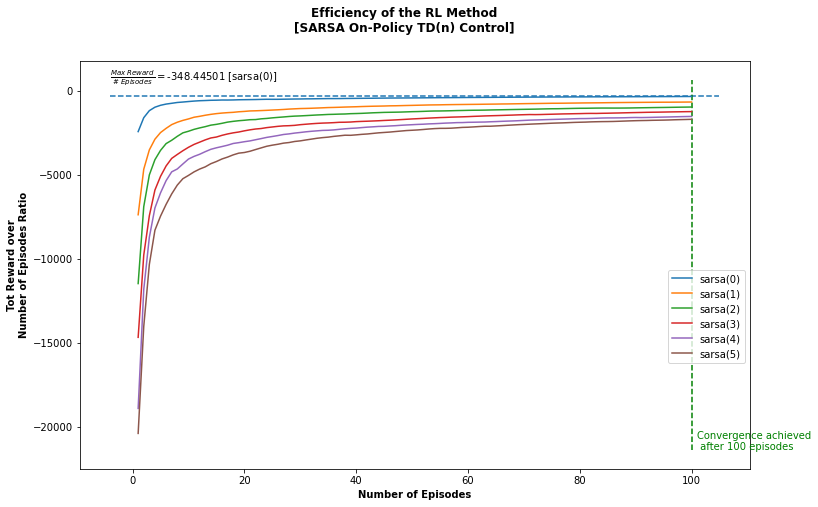

In [14]:
title = 'Efficiency of the RL Method\n[SARSA On-Policy TD(n) Control]'
plotutls.plot_learning_curve(rewards_per_trial_On_Policy_SARSA, title=title, 
                             cumulative_reward=True, lower_reward_ratio=None)

Visualize agent's move which is suggested by the solutions.

In [19]:
for trial in list(RL_trials.keys()):
    print('\n', trial, ':')
    q_vals = q_values_per_trial_On_Policy_SARSA[trial]
    # q_vals = np.round(q_values_per_trial_On_Policy_SARSA[trial], decimals=2)
    print_optimal_policy(q_vals, grid_height=4, grid_width=12)


 sarsa(0) :
→ → → → → → → → → → → ↓
↑ → → → ↑ → → → → → → ↓
↑ ↑ ↑ ↑ → ↑ ↑ ↑ ↑ ↑ → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(1) :
→ → → → → → → → → → → ↓
↑ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(2) :
→ → → → → → → → → → ↓ ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(3) :
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(4) :
→ → → → → → → → → → → ↓
↑ ↑ → → → → → → → → → ↓
↑ ↑ → ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(5) :
→ → → → → → → → → → → ↓
↑ ↑ ↓ → → → → → → → → ↓
→ → → ← ↑ ↑ ↑ ↑ ↑ → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G


### 3b. Expected SARSA: On-Policy TD(n) Control

In [30]:
# Define TD(n) execution parameters
runs = 10         # Number of Independent Runs
n_episodes = 100   # Number of Episodes

# Various n-steps SARSA algorithms to try
print('Determine the n-steps your are interested to explore...\n')
n_step_min = 2; n_step_max = 6
n_steps = np.arange(n_step_min, n_step_max + 1)
print('n_steps: {}'.format(n_steps), '\n')

# various discount factors to try
discount_fixed = 1.
print('Determine a fixed discount factor: {}\n'.format(discount_fixed))

# various step size parameters to try
step_size_fixed = 0.7
print('Determine a fixed step-size: {}\n'.format(step_size_fixed))

# various epsilon parameters to try
epsilon_fixed = 0.1
print('Determine a fixed epsilon: {}\n'.format(epsilon_fixed))

# Create a mesh-grid of trials
print('Create a dictionary of the RL-models of interest...\n')
n_steps, discounts = np.meshgrid(n_steps, discount_fixed)
n_steps = n_steps.flatten()
discounts = discounts.flatten()

# Create a dictionary of the RL-trials of interest
RL_trials = {"sarsa(0)":
             {'epsilon': epsilon_fixed,
              'step_size': step_size_fixed, 'discount': discount_fixed, 'n_step': 1}}

for n, trial in enumerate(list(zip(n_steps, discounts))):
    key = 'sarsa({})'.format(trial[0]-1)
    RL_trials[key] = {'epsilon': epsilon_fixed, 
                      'step_size': step_size_fixed, 'discount': trial[1], 'n_step': trial[0]}
print('Number of RL-models to try: {}\n'.format(len(RL_trials)))

print('Let all RL-models to be trained for {0:,} episodes and {1:,} independent runs...\n'.format(int(n_episodes), int(runs)))

rewards_per_trial_On_Policy_ExpSARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())
q_values_per_trial_On_Policy_ExpSARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())


for trial, params_dict in RL_trials.items():
     
    # Read out parameters from "params_dict"
    epsilon = params_dict['epsilon']
    step_size = params_dict['step_size']
    discount = params_dict['discount']
    n_step = params_dict['n_step']
    
    # Apply SARSA [on-policy TD(n) Control]
    q_values, tot_rewards = TD.expected_sarsa_on_policy_control(env,
                                                                runs=runs, n_episodes=n_episodes, n_step=n_step,
                                                                step_size=step_size, discount=discount, epsilon=epsilon)
    
    # Update "rewards_per_trial" and "q_values_per_trial" OrderedDicts
    rewards_per_trial_On_Policy_ExpSARSA[trial] = tot_rewards
    q_values_per_trial_On_Policy_ExpSARSA[trial] = q_values

Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Determine the n-steps your are interested to explore...

n_steps: [2 3 4 5 6] 

Determine a fixed discount factor: 1.0

Determine a fixed step-size: 0.7

Determine a fixed epsilon: 0.1

Create a dictionary of the RL-models of interest...

Number of RL-models to try: 6

Let all RL-models to be trained for 100 episodes and 10 independent runs...

Training RL-model: sarsa(0)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(1)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(2)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(3)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(4)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(5)...


Independent Runs: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


Verify the learning curves of the RL-models we trained.

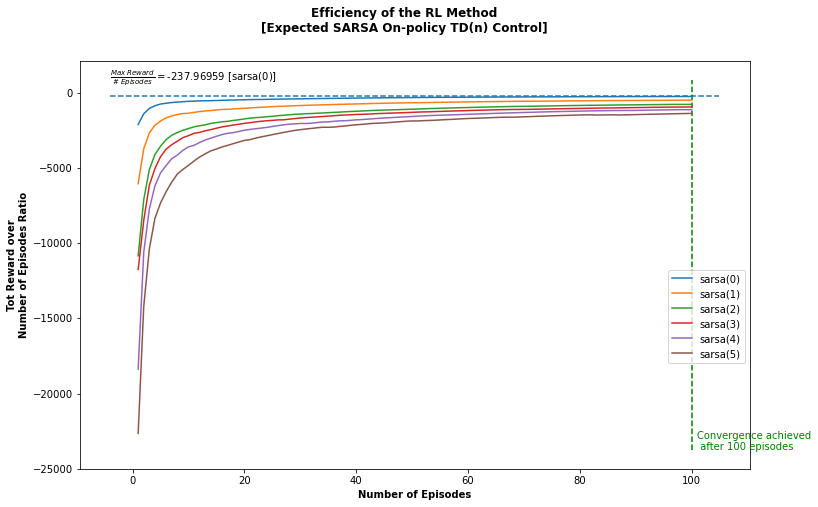

In [31]:
title = 'Efficiency of the RL Method\n[Expected SARSA Οn-policy TD(n) Control]'
plotutls.plot_learning_curve(rewards_per_trial_On_Policy_ExpSARSA,title=title,
                             cumulative_reward=True, lower_reward_ratio=None)

Visualize agent's move which is suggested by the solutions.

In [33]:
for trial in list(RL_trials.keys()):
    print('\n', trial, ':')
    q_vals = q_values_per_trial_On_Policy_ExpSARSA[trial]
    # q_vals = np.round(q_values_per_trial_On_Policy_ExpSARSA[trial], decimals=2)
    print_optimal_policy(q_vals, grid_height=4, grid_width=12)


 sarsa(0) :
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(1) :
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(2) :
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(3) :
→ → → → → → → → → → → ↓
↑ → → → → → → → → → → ↓
↑ → → ↑ ↑ → → ↑ → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(4) :
→ → → → → → → → → → → ↓
↑ → → → → → → → → → → ↓
↑ → ↑ → → → ↑ ↑ → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(5) :
→ → → → → → → → → → → ↓
→ ↑ ↑ → → → → → → → → ↓
↑ ↑ ↑ ↑ → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G


### 3c. SARSA: Off-Policy TD(n) Control

In [20]:
# Define TD(n) execution parameters
runs = 10          # Number of Independent Runs
n_episodes = 200   # Number of Episodes

# Various n-steps SARSA algorithms to try
print('Determine the n-steps your are interested to explore...\n')
n_step_min = 2; n_step_max = 6
n_steps = np.arange(n_step_min, n_step_max + 1)
print('n_steps: {}'.format(n_steps), '\n')

# various discount factors to try
discount_fixed = 1.
print('Determine a fixed discount factor: {}\n'.format(discount_fixed))

# various step size parameters to try
step_size_fixed = 0.5
print('Determine a fixed step-size: {}\n'.format(step_size_fixed))

# various epsilon parameters to try
epsilon_fixed = 0.1
print('Determine a fixed epsilon: {}\n'.format(epsilon_fixed))

# Create a mesh-grid of trials
print('Create a dictionary of the RL-models of interest...\n')
n_steps, discounts = np.meshgrid(n_steps, discount_fixed)
n_steps = n_steps.flatten()
discounts = discounts.flatten()

# Create a dictionary of the RL-trials of interest
RL_trials = {"sarsa(0)":
             {'epsilon': epsilon_fixed,
              'step_size': step_size_fixed, 'discount': discount_fixed, 'n_step': 1}}

for n, trial in enumerate(list(zip(n_steps, discounts))):
    key = 'sarsa({})'.format(trial[0]-1)
    RL_trials[key] = {'epsilon': epsilon_fixed, 
                      'step_size': step_size_fixed, 'discount': trial[1], 'n_step': trial[0]}
print('Number of RL-models to try: {}\n'.format(len(RL_trials)))

print('Let all RL-models to be trained for {0:,} episodes and {1:,} independent runs...\n'.format(int(n_episodes), int(runs)))

rewards_per_trial_Off_Policy_SARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())
q_values_per_trial_Off_Policy_SARSA = OrderedDict((label, np.array([])) for label, _ in RL_trials.items())


for trial, params_dict in RL_trials.items():
     
    # Read out parameters from "params_dict"
    epsilon = params_dict['epsilon']
    step_size = params_dict['step_size']
    discount = params_dict['discount']
    n_step = params_dict['n_step']
    
    # Apply SARSA [on-policy TD(n) Control]
    q_values, tot_rewards = TD.sarsa_off_policy_control(env,
                                                        runs=runs, n_episodes=n_episodes, n_step=n_step,
                                                        step_size=step_size, discount=discount, epsilon=epsilon)
    
    # Update "rewards_per_trial" and "q_values_per_trial" OrderedDicts
    rewards_per_trial_Off_Policy_SARSA[trial] = tot_rewards
    q_values_per_trial_Off_Policy_SARSA[trial] = q_values

Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Determine the n-steps your are interested to explore...

n_steps: [2 3 4 5 6] 

Determine a fixed discount factor: 1.0

Determine a fixed step-size: 0.5

Determine a fixed epsilon: 0.1

Create a dictionary of the RL-models of interest...

Number of RL-models to try: 6

Let all RL-models to be trained for 200 episodes and 10 independent runs...

Training RL-model: sarsa(0)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(1)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(2)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(3)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(4)...


Independent Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Training RL-model: sarsa(5)...


Independent Runs: 100%|██████████| 10/10 [10:56<00:00, 65.67s/it]


Verify the learning curves of the RL-models we trained.

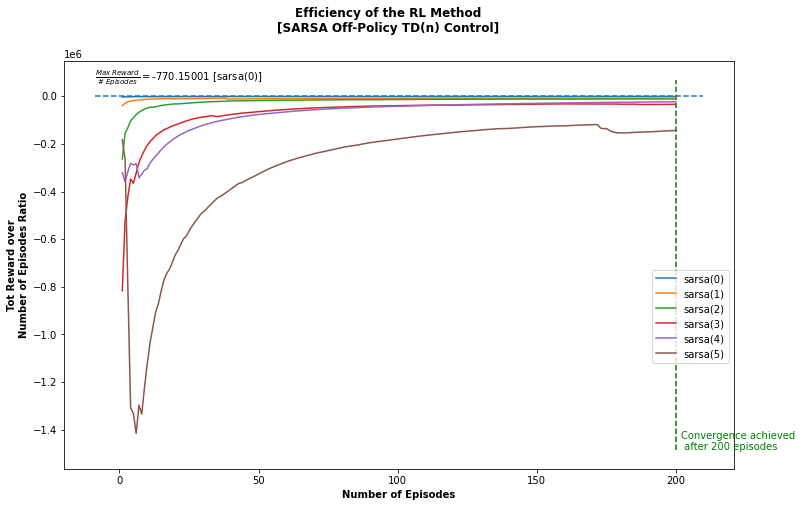

In [21]:
title = 'Efficiency of the RL Method\n[SARSA Off-Policy TD(n) Control]'
plotutls.plot_learning_curve(rewards_per_trial_Off_Policy_SARSA,title=title,
                             cumulative_reward=True, lower_reward_ratio=None)

Visualize agent's move which is suggested by the solutions.

In [22]:
for trial in list(RL_trials.keys()):
    print('\n', trial, ':')
    q_vals = q_values_per_trial_Off_Policy_SARSA[trial]
    # q_vals = np.round(q_values_per_trial_Off_Policy_SARSA[trial], decimals=2)
    print_optimal_policy(q_vals, grid_height=4, grid_width=12)


 sarsa(0) :
↑ → → → → → ← ↓ ↓ → ↓ ↓
↑ ← → → → ↓ ↑ → ↑ ← ↓ ↓
→ ↑ → → → ↑ → ↑ → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(1) :
→ → → → ↓ ← ← → → ↓ ↓ ↓
→ → → → → → → → ← ↓ → ↓
↑ → ↑ → → → ← → → → → ↓
↓ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(2) :
↓ → ← → → → → → → ↓ ↑ ↓
→ → ↓ ↓ ↑ → → → → → → ↓
↓ ↑ → ← ↑ → ← → ↑ → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(3) :
→ ↓ → → → → ↓ ↓ → ↓ ↓ ↓
← → ← ↑ → ↑ → ↑ ← → → ↓
↑ → → → ↑ → ← → ← → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(4) :
← → ↓ ↓ → ← → ↓ ↓ ← ↓ ↓
↓ ↓ ↑ ↓ → → → → → → ↓ ↓
↑ ↑ ↑ → ↑ ↑ → ↑ → ← → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G

 sarsa(5) :
→ → → → → → ↓ → ← → → ←
↑ ↓ ← ↑ ← → → ↑ → → ↑ ↓
↑ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ G
